## Imports

In [1]:
import os
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from pthflops import count_ops
from torchvision import transforms
from prettytable import PrettyTable
from matplotlib.pyplot import imshow
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

In [2]:
print(torch.__version__)

1.10.1+cpu


## Visualization

### Channels

The folder contains 8400 images.


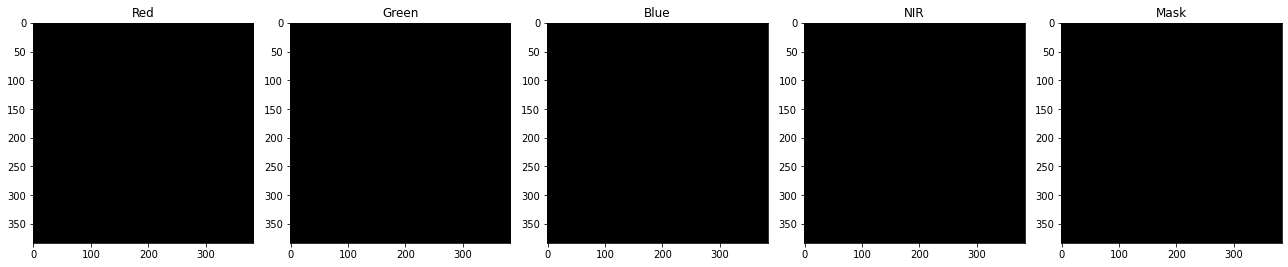

In [3]:
RED_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\38-Cloud_training\train_red" + "\\"
GREEN_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\38-Cloud_training\train_green" + "\\"
BLUE_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\38-Cloud_training\train_blue" + "\\"
NIR_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\38-Cloud_training\train_nir" + "\\"
GT_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\38-Cloud_training\train_gt" + "\\"

red_images = os.listdir(RED_PATH)
green_images = os.listdir(GREEN_PATH)
blue_images = os.listdir(BLUE_PATH)
nir_images = os.listdir(NIR_PATH)
gt_images = os.listdir(NIR_PATH)

print(f'The folder contains {len(red_images)} images.')

image_path = random.choice(red_images)
red_image = Image.open(RED_PATH + image_path)
green_image = Image.open(GREEN_PATH + image_path.replace("red", "green"))
blue_image = Image.open(BLUE_PATH + image_path.replace("red", "blue"))
nir_image = Image.open(NIR_PATH + image_path.replace("red", "nir"))
gt_image = Image.open(GT_PATH + image_path.replace("red", "gt"))

fig, axs = plt.subplots(1, 5, figsize=(18, 18))
axs[0].imshow(red_image, cmap='gray')
axs[0].set_title('Red')
axs[1].imshow(green_image, cmap='gray')
axs[1].set_title('Green')
axs[2].imshow(blue_image, cmap='gray')
axs[2].set_title('Blue')
axs[3].imshow(nir_image, cmap='gray')
axs[3].set_title('NIR')
axs[4].imshow(gt_image, cmap='gray')
axs[4].set_title('Mask')

fig.tight_layout()
plt.show()

### Array

In [4]:
mask = np.array(gt_image)
print(f'Mask shape {mask.shape}')
print(f'Min = {mask.min()} , Max = {mask.max()}')
print(mask)

Mask shape (384, 384)
Min = 0 , Max = 0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Dataloading

### Data Split

In [5]:
train_length = int(len(red_images) * 0.7)
valid_length = int(len(red_images) * 0.2)
test_length = int(len(red_images) * 0.2)

images = np.split(red_images, [train_length, train_length + valid_length, len(red_images)])
train_images = images[0]
valid_images = images[1]
test_images = images[2]

print(f'Train images: {len(train_images)}')
print(f'Valid images: {len(valid_images)}')
print(f'Test  images: {len(test_images)}')
print(f'Total images: {len(train_images) + len(valid_images) + len(test_images)}')

Train images: 5880
Valid images: 1680
Test  images: 840
Total images: 8400


In [6]:
train_list = []
valid_list = []
test_list = []

r_dir = Path(RED_PATH)

for file_name in train_images:
    train_list.append(RED_PATH + file_name)
        
for file_name in valid_images:
    valid_list.append(RED_PATH + file_name)

for file_name in test_images:
    test_list.append(RED_PATH + file_name)

images = (train_list, valid_list, test_list)

### Dataset

In [7]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, file_list):
        super().__init__()
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in file_list if not os.path.isdir(f)]
        
    def combine_files(self, r_file: Path, g_dir, b_dir, nir_dir, gt_dir):
        files = {
            'red': r_file, 
            'green': r_file.replace('red', 'green'),
            'blue': r_file.replace('red', 'blue'), 
            'nir': r_file.replace('red', 'nir'),
            'gt': r_file.replace('red', 'gt')
        }
        return files
                                       
    def __len__(self):
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):
        raw_rgb = np.stack([
            np.array(Image.open(self.files[idx]['red'])),
            np.array(Image.open(self.files[idx]['green'])),
            np.array(Image.open(self.files[idx]['blue'])),
        ], axis=2)
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max) # normalized


    def open_mask(self, idx, add_dims=False):
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        x = torch.tensor(self.open_as_array(idx, invert=True, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.long)
        return x, y
    
    def __repr__(self):
        return f'Dataset class with {self.__len__()} files'

In [8]:
train_dataset = CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, images[0])
valid_dataset = CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, images[1])
test_dataset = CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, images[2])

print(train_dataset)
print(valid_dataset)
print(test_dataset)

Dataset class with 5880 files
Dataset class with 1680 files
Dataset class with 840 files


In [9]:
# single input example
x, y = train_dataset[0]
print(f'Image: {x.shape}')
print(f'Mask: {y.shape}')

Image: torch.Size([4, 384, 384])
Mask: torch.Size([384, 384])


### Dataloader

In [10]:
# Constants
BATCH_SIZE = 16
NUM_WORKER = 0
NUM_EPOCHS = 15
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {DEVICE} device.")

Using cpu device.


In [11]:
def my_collate(batch):
    batch = list(filter (lambda x:torch.sum(x[0]).item() != 0, batch))
    if len(batch) == 0:
        print("DOOOOO")
    return torch.utils.data.dataloader.default_collate(batch)

In [12]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)
valid_loader = DataLoader(valid_dataset, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)

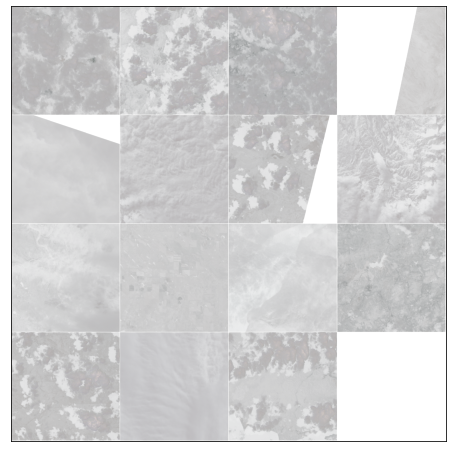

In [13]:
# View batch
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
    break

## Training

### Model

In [14]:
class depthwiseSeparableConv(nn.Module):
    def __init__(self, nin, nout):
        super(depthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

Using cpu device


In [15]:
class C_UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = self.contract_block(in_channels, 32)
        self.conv2 = self.contract_block(32, 64)
        self.conv3 = self.contract_block(64, 128)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64, 32, 3, 1)
        self.upconv1 = self.expand_block(32, out_channels, 3, 1)

        self.out = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 1),
            nn.Sigmoid()
        )


    def __call__(self, x):
        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(upconv3)
        upconv1 = self.upconv1(upconv2)

        out = self.out(upconv1)

        return out


    def contract_block(self, in_channels, out_channels):
        contract = nn.Sequential(
            depthwiseSeparableConv(in_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        return contract


    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
        )
        return expand

In [16]:
model = C_UNet(4, 2)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

def accuracy(predb, yb):
    return (predb.argmax(dim=1) == yb).float().mean().item()

In [17]:
# Overall metrics
train_losses = []
valid_losses = []
valid_accuracies = []

for epoch in range(NUM_EPOCHS):
    # TRAIN
    model.train()

    # Epoch metrics
    train_loss = []
    valid_loss = []
    valid_acc = []

    # Load training batch
    for images, targets in tqdm(train_loader):
        # Send to device
        images = images.to(DEVICE)
        targets = targets.to(DEVICE)

        # Loss
        predictions = model(images)
        loss = criterion(predictions, targets)
        train_loss.append(loss.item())
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Back Propagation
        loss.backward()
        
        # Scheduler
        # lr_scheduler.step()
        
        # Update the parameters
        optimizer.step()

    # EVALUATION
    model.eval()

    # Load validation batch
    for images, targets in tqdm(valid_loader):
        with torch.no_grad():
            # Send to device
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)

            # Loss
            predictions = model(images)
            loss = criterion(predictions, targets)
            valid_loss.append(loss.item())
            
            # Accuracy
            valid_acc.append(accuracy(predictions, targets))

    # Log
    train_losses.append(np.mean(train_loss))
    valid_losses.append(np.mean(valid_loss))
    valid_accuracies.append(np.mean(valid_acc))
    print(f'Epoch [{epoch + 1}], train_loss: {train_losses[-1]}, val_loss: {valid_losses[-1]}, val_acc: {valid_accuracies[-1]}')

 92%|█████████▏| 97/105 [02:13<00:11,  1.38s/it]

DOOOOO


IndexError: list index out of range

In [ ]:
test_accuracies = []
test_loss = []

model.to(DEVICE)
model.eval()

# Load testing batch
for images, targets in tqdm(test_loader):
    with torch.no_grad():
        # Send to device
        images = images.to(DEVICE)
        targets = targets.to(DEVICE)

        # Loss
        predictions = model(images)
        loss = criterion(predictions, targets)
        test_loss.append(loss.item())

        # Accuracy
        test_accuracies.append(accuracy(predictions, targets))

# Log
print(f'Model Evaluation, Loss: {np.mean(test_loss)}, Accuracy: {np.mean(test_accuracies)}')

100%|██████████| 53/53 [00:12<00:00,  4.27it/s]

Model Evaluation, Loss: 0.27033583974500874, Accuracy: 0.9064232976931446


### Save Model

In [ ]:
torch.save(model.state_dict(), f"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\38-Cloud_training\c_unet_{time.time()}.pth")

### Evaluate Model

In [ ]:
MODEL_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\model_test\c_unet_1647162803.6921902.pth"

In [ ]:
# Load the saved model
model = C_UNet(4, 2)
model.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
model.eval()

In [ ]:
def get_mask(pred):
    mask_pred = np.zeros([384,384,3])
    mask_pred[:,:,0] = pred[:,0,:,:] * 255
    mask_pred[:,:,1] = pred[:,1,:,:] * 255
    return mask_pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


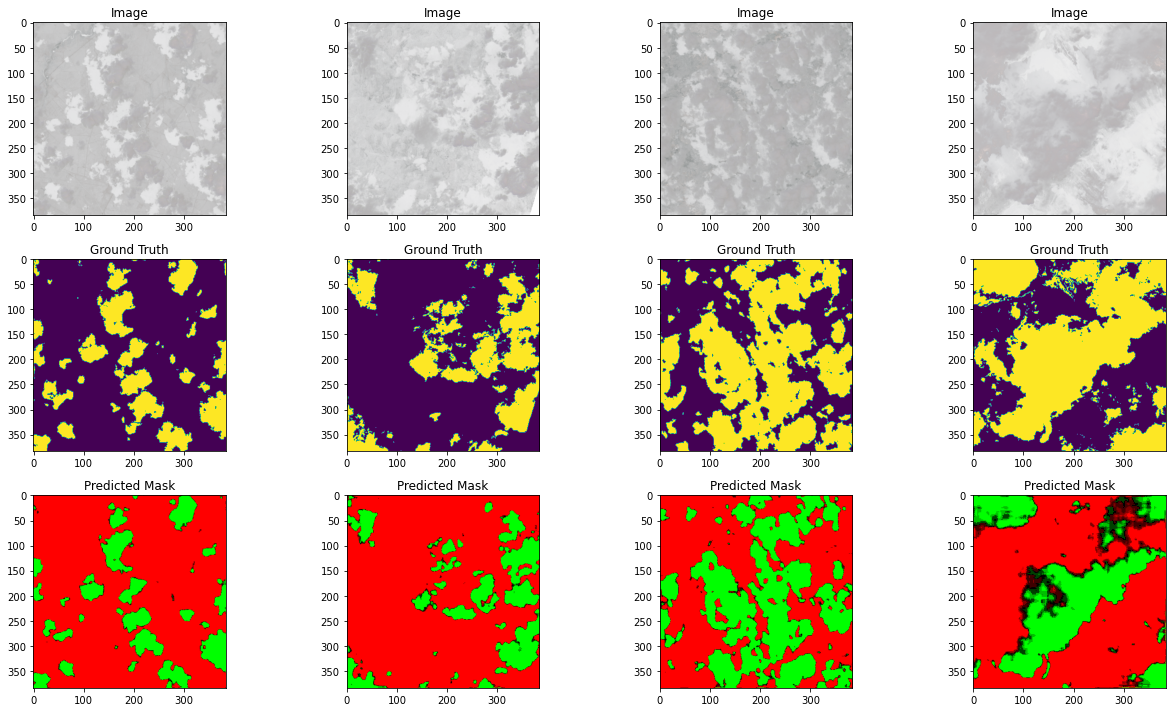

In [ ]:
images = [
    test_dataset[0],
    test_dataset[1],
    test_dataset[5],
    test_dataset[6]
]

fig, axs = plt.subplots(3, len(images), figsize=(18, 10))

i = 0

for image in images:
    # Retrieve and format results
    display_im = image[0].permute(1, 2, 0).cpu().detach().numpy()
    pred = model(image[0].unsqueeze(0)).cpu().detach().numpy()
    pred = get_mask(pred)
    mask = image[1]
    
    # Display
    axs[0][i].imshow(display_im)
    axs[0][i].set_title('Image')
    axs[1][i].imshow(mask)
    axs[1][i].set_title('Ground Truth')
    axs[2][i].imshow(pred)
    axs[2][i].set_title('Predicted Mask')
    
    # Increment count
    i += 1

fig.tight_layout()
plt.show()

### Analysis

#### Number of parameters

In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
count_parameters(model)

+------------------+------------+
|     Modules      | Parameters |
+------------------+------------+
|  conv1.0.weight  |    6272    |
|   conv1.0.bias   |     32     |
|  conv1.1.weight  |     32     |
|   conv1.1.bias   |     32     |
|  conv1.3.weight  |   50176    |
|   conv1.3.bias   |     32     |
|  conv1.4.weight  |     32     |
|   conv1.4.bias   |     32     |
|  conv2.0.weight  |   18432    |
|   conv2.0.bias   |     64     |
|  conv2.1.weight  |     64     |
|   conv2.1.bias   |     64     |
|  conv2.3.weight  |   36864    |
|   conv2.3.bias   |     64     |
|  conv2.4.weight  |     64     |
|   conv2.4.bias   |     64     |
|  conv3.0.weight  |   73728    |
|   conv3.0.bias   |    128     |
|  conv3.1.weight  |    128     |
|   conv3.1.bias   |    128     |
|  conv3.3.weight  |   147456   |
|   conv3.3.bias   |    128     |
|  conv3.4.weight  |    128     |
|   conv3.4.bias   |    128     |
| upconv3.0.weight |   73728    |
|  upconv3.0.bias  |     64     |
| upconv3.1.we

538934

#### Number of FLOPS

In [ ]:
# Sample input
inp = torch.rand(1, 4, 384, 384)

# Count the number of FLOPs
count_ops(model, inp)

FX is unsupported on your pytorch version, falling back to JIT


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pthflops/__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)


Operation                                            OPS          
---------------------------------------------------  -----------  
Sequential/Conv2d[0]/onnx::Conv                      929562624    
Sequential/BatchNorm2d[1]/onnx::BatchNormalization   9437184      
Sequential/ReLU[2]/onnx::Relu                        9437184      
Sequential/Conv2d[3]/onnx::Conv                      7398752256   
Sequential/BatchNorm2d[4]/onnx::BatchNormalization   9437184      
Sequential/ReLU[5]/onnx::Relu                        9437184      
Sequential/MaxPool2d[6]/onnx::MaxPool                9437184      
Sequential/Conv2d[0]/onnx::Conv                      679477248    
Sequential/BatchNorm2d[1]/onnx::BatchNormalization   4718592      
Sequential/ReLU[2]/onnx::Relu                        4718592      
Sequential/Conv2d[3]/onnx::Conv                      1358954496   
Sequential/BatchNorm2d[4]/onnx::BatchNormalization   4718592      
Sequential/ReLU[5]/onnx::Relu                        4718592  

(13215154176,
 [['Sequential/Conv2d[0]/onnx::Conv', 929562624],
  ['Sequential/BatchNorm2d[1]/onnx::BatchNormalization', 9437184],
  ['Sequential/ReLU[2]/onnx::Relu', 9437184],
  ['Sequential/Conv2d[3]/onnx::Conv', 7398752256],
  ['Sequential/BatchNorm2d[4]/onnx::BatchNormalization', 9437184],
  ['Sequential/ReLU[5]/onnx::Relu', 9437184],
  ['Sequential/MaxPool2d[6]/onnx::MaxPool', 9437184],
  ['Sequential/Conv2d[0]/onnx::Conv', 679477248],
  ['Sequential/BatchNorm2d[1]/onnx::BatchNormalization', 4718592],
  ['Sequential/ReLU[2]/onnx::Relu', 4718592],
  ['Sequential/Conv2d[3]/onnx::Conv', 1358954496],
  ['Sequential/BatchNorm2d[4]/onnx::BatchNormalization', 4718592],
  ['Sequential/ReLU[5]/onnx::Relu', 4718592],
  ['Sequential/MaxPool2d[6]/onnx::MaxPool', 4718592],
  ['Sequential/Conv2d[0]/onnx::Conv', 679477248],
  ['Sequential/BatchNorm2d[1]/onnx::BatchNormalization', 2359296],
  ['Sequential/ReLU[2]/onnx::Relu', 2359296],
  ['Sequential/Conv2d[3]/onnx::Conv', 1358954496],
  ['Sequen

## Results

### Validation Accuracy

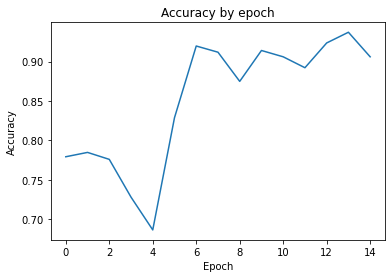

In [ ]:
plt.plot(valid_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy by epoch');

### Losses

Text(0.5, 1.0, 'Losses by epoch')

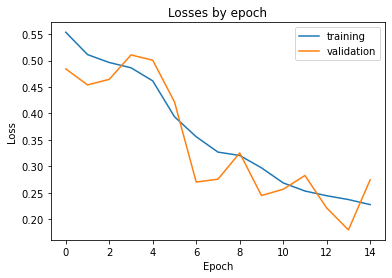

In [ ]:
plt.plot(train_losses, label="training")
plt.plot(valid_losses, label="validation")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses by epoch')